|  Sunrise logo | ![EEW logo](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/eew.jpg?raw=true) | ![EDGI logo](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/edgi.png?raw=true) |
|---|---|---|

#### This notebook is licensed under GPL 3.0. Please visit [our Github repo](https://github.com/edgi-govdata-archiving/ECHO-COVID19) for more information.
#### The notebook was collaboratively authored by the Environmental Data & Governance Initiative (EDGI) following our [authorship protocol](https://docs.google.com/document/d/1CtDN5ZZ4Zv70fHiBTmWkDJ9mswEipX6eCYrwicP66Xw/). It was developed by EDGI for Sunrise Boston to assist them in analyzing data on greenhouse gas emissions and other pollutants in Massachusetts. For more information about our project, visit https://www.environmentalenforcementwatch.org/
#### The data you will interact with here is a copy of several tables from [EPA's Enforcement and Compliance History database](https://echo.epa.gov/tools/data-downloads#downloads). Our copy is stored on a server at Stonybrook University and is updated every Sunday (latest refresh: July 12, 2020)

## How to Run this Notebook
* A "cell" in a Jupyter notebook is a block of code performing a set of actions making available or using specific data.  The notebook works by running one cell after another, as the notebook user selects offered options.
* If you click on a gray **code** cell, a little “play button” arrow appears on the left. If you click the play button, it will run the code in that cell (“**running** a cell”). The button will animate. When the animation stops, the cell has finished running.
![Where to click to run the cell](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/pressplay.JPG?raw=true)
* You may get a warning that the notebook was not authored by Google. We know, we authored them! It’s okay. Click “Run Anyway” to continue. 
![Error Message](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/warning-message.JPG?raw=true)
* **It is important to run cells in order because they depend on each other.**
* Run all of the cells in a Notebook to make a complete report. Please feel free to look at and **learn about each result as you create it**!
* As you run this notebook, we will automatically export spreadsheet versions of the data. Click on the 'Files' tab in the menu on the left-hand side of the notebook (it looks like a folder). You may have to hit 'Refresh' if you don't see your file. Then, you can click on the ... next to your file and choose "Download". The CSV spreadsheet will download to wherever your browser usually saves files (e.g. Downloads folder)

# **Let's begin!** 
These first few cells give us access to some external Python code we will need. Hover over the "[ ]" on the top left corner of the cell below and you should see a "play" button appear. Click on it to run the cell then move to the next one.
### 0.  Bring in extra code

In [1]:
# Code stored in Github projects
!git clone -b program-specific-info --single-branch https://github.com/ericnost/ECHO_modules.git &>/dev/null;
!git clone -b sunrise --single-branch https://github.com/edgi-govdata-archiving/ECHO-Geo.git &>/dev/null; # Do Sunrise-specific branch with fewer geos
!git clone -b main --single-branch https://github.com/edgi-govdata-archiving/ECHO-Sunrise.git &>/dev/null; # This has the utilities file for mapping and make_data_sets.py 

In [2]:
# Import main code libraries
%run ECHO_modules/DataSet.py
%run ECHO-Sunrise/utilities.py
import pandas as pd
!pip install geopandas &>/dev/null;
import geopandas
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import requests
import csv
import datetime
import ipywidgets as widgets  
from IPython.core.display import display, HTML

### 1. Choose a Congressional District
In the following cell, load a map of MA's Congressional Districts. Mouse over each to see its district number, then choose which one you want to focus on from the dropdown menu created by the second cell.

In [3]:
options=['Congressional District 4', 'Congressional District 5', 'Congressional District 6', 
         'Congressional District 7', 'Congressional District 8',]

# Read in and map geojson for the selected geography
cd_data = geopandas.read_file("ECHO-Geo/ma_congressional_districts.geojson")

m = folium.Map()

def style_function(feature):
    return {
        'fillOpacity': .5 if feature['properties']['District'] in options else .25,
        'weight': 1.5 if feature['properties']['District'] in options else .5,
        'color': 'black',
        'fillColor': 'blue' if feature['properties']['District'] in options else "grey"
    }

cd = folium.GeoJson(
    cd_data,
    name = "Congressional Districts",
    style_function=style_function
).add_to(m)
folium.GeoJsonTooltip(fields=["District"]).add_to(cd)

bounds = m.get_bounds()
m.fit_bounds(bounds)

m

In [4]:
select_region_widget = widgets.Dropdown(
    options=options,
    value='Congressional District 7',
    description='Select a District:',
    disabled=False
)

display( select_region_widget )

Dropdown(description='Select a District:', index=3, options=('Congressional District 4', 'Congressional Distri…

### 3. What kinds of facilities does EPA track in this district and across MA?
This may take just a little bit of time to load - there are thousands!

In [5]:
# Get the EPA data from the Stonybrook University database
echo_data_sql = "select * from ECHO_EXPORTER where FAC_STATE = 'MA' and FAC_ACTIVE_FLAG='Y' " 
echo_data = get_data( echo_data_sql, 'REGISTRY_ID' )
num_facilities = echo_data.shape[0]

# Get selected district
geo_json_data = cd_data[(cd_data["District"] == select_region_widget.value)] #where ids match

# Join the facilities and the chosen district
this_district_data = echo_data.loc[(echo_data["FAC_DERIVED_CD113"]==float(select_region_widget.value.strip("Congressional District")))]

# Summarize 
display(HTML("<h3>There are %s facilities in Massachussets currently tracked in the ECHO database." %(num_facilities)))
display(HTML("<h3>There are "+ str(this_district_data.shape[0]) + " facilities in this district."))
display(HTML("<h3>There are "+ str(this_district_data.loc[this_district_data["RCRA_FLAG"] == "Y"].shape[0]) + " facilities regulated under RCRA in this district.</h3>"))
display(HTML("<h3>There are "+ str(this_district_data.loc[this_district_data["NPDES_FLAG"] == "Y"].shape[0]) + " facilities regulated under CWA in this district.</h3>"))
display(HTML("<h3>There are "+ str(this_district_data.loc[this_district_data["AIR_FLAG"] == "Y"].shape[0]) + " facilities regulated under CAA in this district.</h3>"))
display(HTML("<h3>There are "+ str(this_district_data.loc[this_district_data["GHG_FLAG"] == "Y"].shape[0]) + " facilities reporting GHGs in this district.</h3>"))

/Users/Eric/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (5,119) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


### 4.  Run this next cell to create to choose how you want to *zoom in* on the data: what program you want to focus on (Air, Water, Waste, or GHG)?
Running the code below will show you a dropdown you can use to make a selection. **Inspections** or **evaluations** are usually the first phase in the enforcement pipeline. This is how many violations, especially under the Clean Air Act, are discovered.  **Violations** happen when a facility is found to be out of compliance with an environmental law, often by violating the terms of its permit issued under that law.  **Enforcement actions** happen when the regulating agency decides to initiate a "case" against a firm for its violation of an environmental law, either by considering some administrative penalty such as a fine or by taking the violator to court. Here we focus on penalties (in $)

What's available for you to look at:

**Hazardous Waste**:
- _Inspections_ of waste handling and disposal facilities under RCRA
- _Violations_ of RCRA rules
- _Penalties_ levied by state agencies and the EPA for RCRA violations

Here's where you can find definitions of terms used in the columns of RCRA data: 
https://echo.epa.gov/tools/data-downloads/rcrainfo-download-summary 

**Air**:
- Both state and federal CAA compliance evaluations (facility _inspections_)
- High priority _violations_ of the CAA
- _Penalties_ levied by state agencies and the EPA for CAA violations

Here's where you can find definitions of terms used in the columns of Clean Air Act data: 
https://echo.epa.gov/tools/data-downloads/icis-air-download-summary

**Greenhouse Gas Reporting Program (GHGRP)**:
- Self-reported emissions of carbon dioxide, methane, etc. in metric tons of CO2 equivalent (mtCO2e), 2010-2018. Only facilities emitting more than 25,000 mtCO2e in a year are required to report.

Here's where you can find definitions of terms used in the columns of this data: https://echo.epa.gov/tools/data-downloads/air-emissions-download-summary and https://www.epa.gov/sites/production/files/2014-12/documents/ghgcalculatorhelp.pdf

**Water** (National Pollutant Discharge Elimination System, or NPDES):
- CWA _inspections_
- CWA effluent _violations_, which is essentially when a facility discharges more water pollutants than it is permitted to.
- CWA _penalties_ levied by both state agencies and the EPA

Here's where you can find definitions of terms used in the columns of Clean Water Act data: https://echo.epa.gov/tools/data-downloads/icis-npdes-download-summary

In [6]:
%run ECHO-Sunrise/make_data_sets.py
data_sets=make_data_sets()

data_set_choices = []
for k, v in data_sets.items():
    if ( v.has_echo_flag( echo_data ) ):
        data_set_choices.append( k )

data_set_widget=widgets.Dropdown(
    options=list(data_set_choices),
    description='Data sets:',
    disabled=False,
    value='Greenhouse Gas Emissions'
) 
display(data_set_widget)

Dropdown(description='Data sets:', index=6, options=('RCRA Violations', 'RCRA Inspections', 'RCRA Penalties', …

### 5. Chart trends
In the first cell, we go and get all the data from the database. This may take a few minutes!
In the second cell, we plot this district's data compared with MA as a whole.

In [ ]:
%run utilities.py

In [175]:
program = data_sets[ data_set_widget.value ] 
program_data = None
district = float(select_region_widget.value.strip("Congressional District"))

key=dict() # Create a way to look up Registry IDs in ECHO_EXPORTER later

#### We need to provide a custom list of program ids for some programs.
if ( program.name == "Greenhouse Gas Emissions"):
    program_flag = program.echo_type + '_FLAG'
    registry_ids = echo_data[echo_data[ program_flag ] == 'Y'].index.values
    program_data = program.get_data( ee_ids=registry_ids )
    key = { i : i for i in registry_ids }
else:
    ids_string = program.echo_type + '_IDS'
    ids = list()
    registry_ids = list()
    for index, value in echo_data[ ids_string ].items():
        try:
            for this_id in value.split():
                ids.append( this_id )
                key[this_id]=index
        except ( KeyError, AttributeError ) as e:
            pass
    program_data = program.get_data( ee_ids=ids )

all_data=program_data

#### Handle special penalties cases...
if (program.name == "CWA Penalties"): 
    program_data[program.agg_col] = program_data["FED_PENALTY_ASSESSED_AMT"].fillna(0) + program_data["STATE_LOCAL_PENALTY_AMT"].fillna(0)  
if (program.name == "RCRA Penalties"): 
    program_data[program.agg_col] =  program_data["FMP_AMOUNT"].fillna(0) # Lots of NaNs here. For now, replace with zero :(

#### Filter to 2010 and later
# Handle CWA separately
if (program.name == "CWA Violations"): 
    year = program_data[program.date_field].astype("str").str[0:4:1]
    program_data[program.date_field] = year
program_data[program.date_field] = pd.to_datetime(program_data[program.date_field], format=program.date_format, errors='coerce')
program_data=program_data.loc[(program_data[program.date_field] >= pd.to_datetime('2010'))] 

#### Aggregate data using agg_col and agg_type from DataSet.py
program_data.reset_index(inplace=True) # By default, DataSet.py indexes the results from the query. But we have to reset the indext to group it.

t = program_data.groupby([program.idx_field,program.date_field])[[program.agg_col]].agg(program.agg_type) # Count inspections and violations, sum emissions and penalties
t=t.groupby([pd.Grouper(level=program.idx_field), 
    pd.Grouper(level=program.date_field, freq='Y')] # Summarize everything by year to make search faster
).sum()

state_bars = program_data.groupby(program.date_field)[[program.agg_col]].agg(program.agg_type) # Sum of total emissions or penalties, or count of inspections or violations, in the district
state_bars = state_bars.resample('Y').sum() # Summarize by year
state_bars.index = state_bars.index.strftime('%Y') # Make the year look pretty e.g. 2018 instead of 2018-12-31.

#### Find the facility that matches the program data, by REGISTRY_ID.  
# Add additional information, like congressional district #, lat and lon, facility name, and the program-specific id (index)
time_data = []
no_data_ids = []

# Look through all the facilities in my area and program and get supplemental echo_data info
if (t is None): # Handle no data
    print("Sorry, we don't have data for this program! That could be an error on our part, or ECHO's, or because the data type doesn't apply to this area.")
else:
    for fac in t.itertuples():
        fac_id = fac.Index[0] # the facility id
        date = fac.Index[1] # the year
        data = fac[1] # the data we want... e.g. annual emissions 
        reg_id = key[fac_id] # Look up this facility's main Registry ID through its Program ID
        try:
            e=echo_data.loc[echo_data.index==reg_id].copy()[['FAC_NAME', 'FAC_DERIVED_CD113', 'FAC_LAT', 'FAC_LONG', 'DFR_URL', 'FAC_PERCENT_MINORITY']].to_dict('index')
            e = e[reg_id] # remove indexer
            e.update({"Index":fac_id, program.date_field : date, program.agg_col : data})
            time_data.append(e)
        except KeyError:
            # The facility wasn't found in the program data.
            no_data_ids.append( fac.Index )

state_bars = pd.DataFrame(state_bars)
time_data = pd.DataFrame(time_data)

97 ids were searched for
2244 program records were found


In [176]:
time_data
d=1
dabars=[]
while d < 10: # for the 9 Congressional Districts
    district_time_data = time_data.loc[(time_data["FAC_DERIVED_CD113"]==d)]
    # Create district bar charts
    district_bars = district_time_data.groupby(program.date_field)[[program.agg_col]].sum() # Sum of total emissions, violations, etc. _in this district_ for the whole year
    district_bars = district_bars.resample('Y').sum() # Resample by year
    district_bars.index = district_bars.index.strftime('%Y')
    x=district_bars.to_dict()
    x = x[program.agg_col]
    dabars.append(x)
    d+=1
d = pd.DataFrame(dabars)
d = d.transpose()
c = {i:i+1 for i in range(0,9)}
d = d.rename(columns=c)
d

,1,2,3,4,5,6,7,8,9
2010,2.866825e+06,1.537216e+06,848688.227431,7.605777e+06,34392.980,2.276705e+06,5465919.914,1701276.042,1.195191e+06
2011,2.715196e+06,1.668091e+06,808508.958281,4.611344e+06,602439.053,1.701704e+06,5212591.562,2077222.578,1.192229e+06
2012,2.495553e+06,1.619420e+06,838099.254510,3.418966e+06,582705.331,1.291839e+06,4914970.159,1814161.970,1.116007e+06
2013,2.323934e+06,1.577043e+06,777499.407800,4.905047e+06,572126.419,1.380603e+06,4156266.394,1720719.990,1.204777e+06
2014,2.361959e+06,1.702693e+06,822252.687050,4.381626e+06,561046.748,1.313714e+06,2456934.960,1782603.778,1.427748e+06
2015,2.524087e+06,1.655004e+06,806433.604940,4.654417e+06,528640.864,1.041598e+06,2922384.834,1699095.976,1.308257e+06
2016,2.069147e+06,1.454903e+06,825479.090000,3.536852e+06,526847.808,1.028568e+06,4117522.114,1706424.382,1.046431e+06
2017,1.645440e+06,1.590771e+06,817994.356000,2.799697e+06,464095.193,9.898850e+05,4413744.478,1911281.398,1.075109e+06
2018,1.602713e+06,1.680841e+06,813347.110000,1.377050e+06,456516.746,1.456218e+06,3363082.782,1496543.552,1.132953e+06


In [ ]:
import time
start = time.time()

program = data_sets[ data_set_widget.value ] 
program_data = None
district = float(select_region_widget.value.strip("Congressional District"))

district_program_data, bars, all_data = get_program_data(echo_data, program, program_data, district)

end=time.time()
print("This took "+str(end-start)+" seconds to run.")

In [177]:
district_program_data = time_data.groupby(["DFR_URL","FAC_DERIVED_CD113", "FAC_LAT","FAC_LONG","FAC_NAME","FAC_PERCENT_MINORITY", "Index"])[[program.agg_col]].sum() # Sum up years
district_program_data.reset_index(inplace=True)
district_program_data = district_program_data.loc[(district_program_data["FAC_DERIVED_CD113"]==district)]

['grey', 'grey', 'grey', 'grey', 'grey', 'grey', '#00C2AB', 'grey', 'grey']


Text(0, 0.5, 'metric tons of CO2 equivalent')

<Figure size 432x288 with 0 Axes>

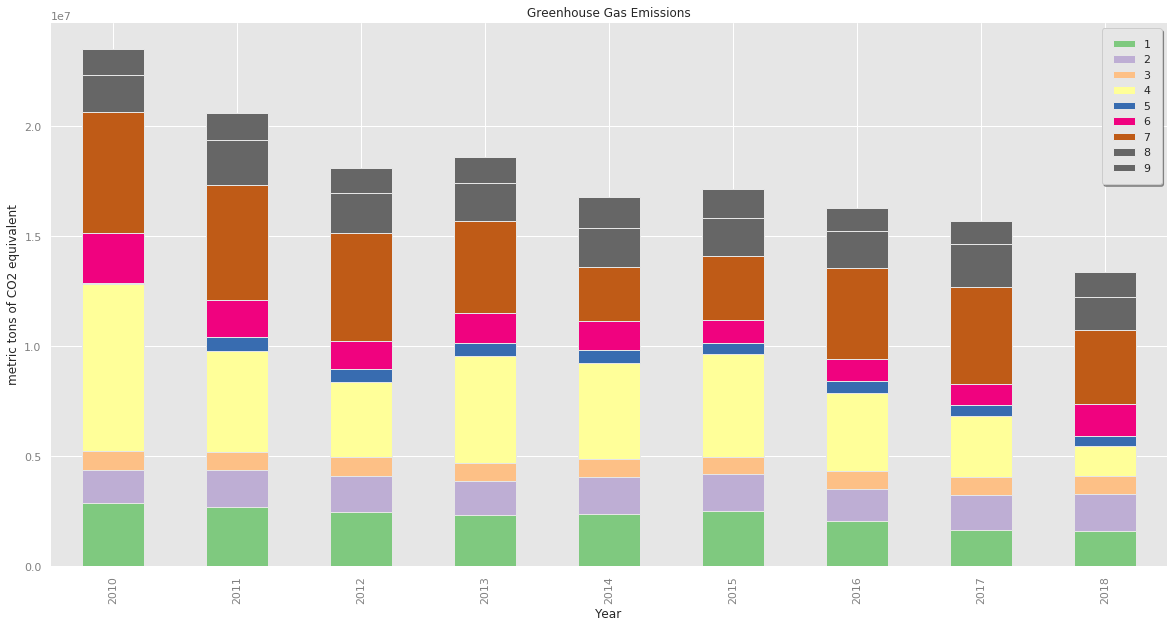

In [179]:
%run ECHO-Sunrise/utilities.py # Load the right style parameters
#plt.figure(figsize=(20,10))
#alpha = 1 if (d.column==district) else .75
c = ["#00C2AB" if (i==district - 1) else "grey" for i in range(0,9)]
print(c)
#linewidth=2, label = "x"
fig, ax = plt.subplots(figsize=(20,10))
g= d.plot(kind="bar", stacked=True, ax=ax, colormap = "Accent")#color=c, linewidth=1, edgecolor="black")
i=0
#for r in g.patches:
#    xy=r.get_xy()
#    if (xy[0] < 0): # first bar only?
#        x = 0.5*r.get_width() + xy[0]
#        y = 0.35*r.get_height() + xy[1]
#        ax.text(x,y, "CD - %s" %(d.columns[i]), ha='center')
#        i+=1
    
#plt.bar(bars.index, bars[program.agg_col])
#plt.bar(bars.index, bars[program.agg_col + " in this District"])
plt.title(program.name)
plt.xlabel( 'Year' )
plt.ylabel( program.unit )
#plt.legend(["Other Districts", "%s" %(select_region_widget.value)])
#plt.show()   

#bars.to_csv("trends-"+program.name+"-MA-"+select_region_widget.value+".csv")

### 6. Rank and map facilities in this district
In the first cell below, we will show the 20 facilities with the most inspections, violations, emissions or penalties (depending on your selection above) in your selected district.
In the second, we will map all facilities, with larger circles indicating more inspections, violations, emissions or penalties. Greyed-out circles are facilities with no recorded inspections, violations, emissions or penalties.

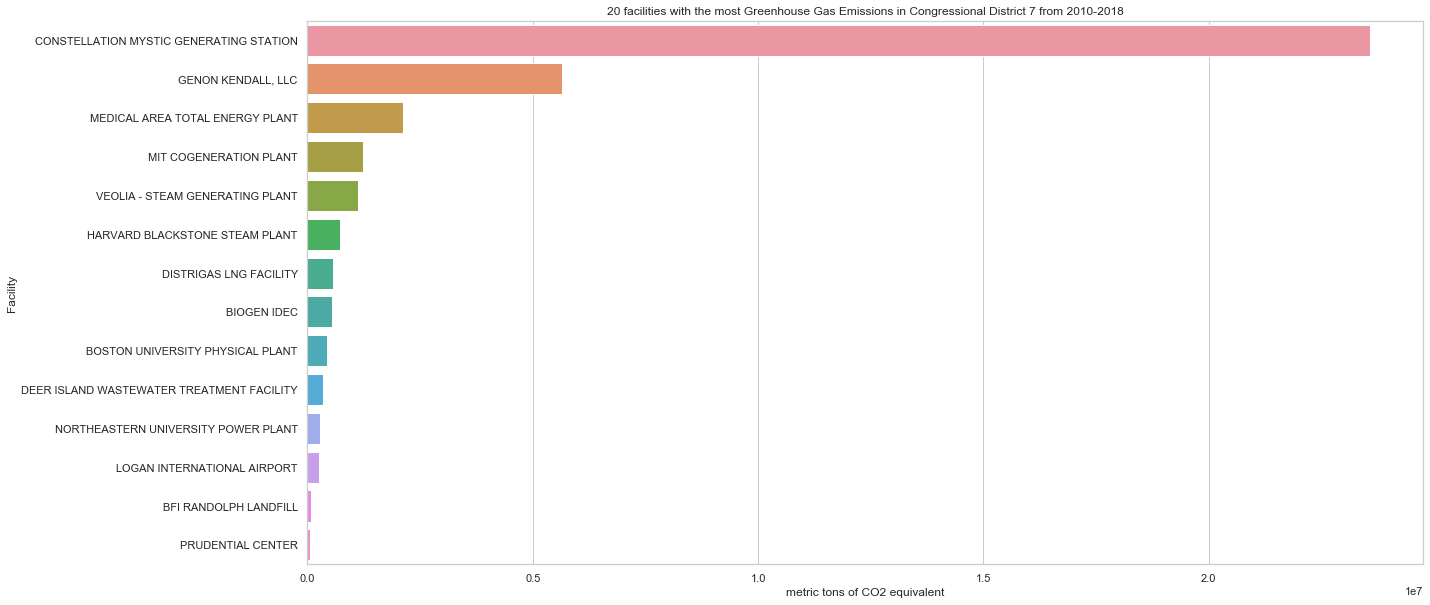

In [165]:
district_program_data.to_csv("district_program_data-"+program.name+"-"+select_region_widget.value+".csv")

if (district_program_data.shape[0] > 0):
    ranked = district_program_data.set_index("Index")
    ranked['quantile'] = pd.qcut(ranked[program.agg_col], 5, labels=False, duplicates="drop")
    ranked = ranked.sort_values(by=program.agg_col, ascending=False)
    ranked.to_csv("facilities_ranked-"+program.name+".csv")

    time = '2018' if (program.name == "Greenhouse Gas Emissions") else '2020'
    sns.set(style='whitegrid')
    fig, ax = plt.subplots(figsize=(20,10))
    unit = ranked[0:19].index # First 20 rows 
    values = ranked[0:19][program.agg_col] # First 20 rows
    g = sns.barplot(values, unit, order=list(unit), orient="h") 
    g.set_title('20 facilities with the most %s in %s from 2010-%s' %(program.name, select_region_widget.value, time))
    ax.set_xlabel(program.unit)
    ax.set_ylabel("Facility")
    ax.set_yticklabels(ranked[0:19]["FAC_NAME"])
    g
else:
    print("There are no reported emissions/violations/etc. to rank here!")

In [181]:
%run utilities.py

<Figure size 432x288 with 0 Axes>

In [182]:
if (district_program_data.shape[0] > 0):
    mp = mapper_area(ranked, geo_json_data, program.agg_col, program.unit, program.echo_type, program.name)
else:
    mp = print("There are no reported emissions/violations/etc. to map here!")
mp

### 7. Accessing your files
Want to download the data tables you created in this notebook? Click on the 'Files' tab in the menu on the left-hand side of the notebook (it looks like a folder). You may have to hit 'Refresh' if you don't see your file. Then, you can click on the ... next to your file and choose "Download". The CSV spreadsheet will download to wherever your browser usually saves files (e.g. Downloads folder)